In [56]:
!pip -qq install torchutils

In [137]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision import transforms as T
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

import numpy as np
# Для чтения изображений с диска
from torchvision import io # input/output
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import vgg16, VGG16_Weights

from PIL import Image
import time

In [59]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/coffee-beans-clf.zip'

In [62]:
import zipfile
import os

# Укажите путь к вашему архиву
extract_path = '/content/dataset/'  # Путь для разархивированных файлов

# Создайте директорию, если она не существует
os.makedirs(extract_path, exist_ok=True)

# Разархивируйте файл
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Разархивирование завершено!")

Разархивирование завершено!


In [63]:
trnsfrms = T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
      ])


In [64]:
train_dataset = torchvision.datasets.ImageFolder(
    '/content/dataset/coffee-beans/train',
    transform=trnsfrms)

In [65]:
valid_dataset = torchvision.datasets.ImageFolder(
    '/content/dataset/coffee-beans/test',
    transform=trnsfrms)

In [66]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [67]:
img = io.read_image('/content/dataset/coffee-beans/train/Dark/dark (1).png')/255
img.shape

torch.Size([3, 224, 224])

In [68]:
for images, labels in train_loader:
    # Извлечение первого изображения и метки
    image = images[0]  # Первое изображение в батче
    label = labels[0]
    print(f"Image shape: {image.shape}")
    print(f"Label: {label}")

Image shape: torch.Size([3, 224, 224])
Label: 2
Image shape: torch.Size([3, 224, 224])
Label: 2
Image shape: torch.Size([3, 224, 224])
Label: 3
Image shape: torch.Size([3, 224, 224])
Label: 2
Image shape: torch.Size([3, 224, 224])
Label: 0
Image shape: torch.Size([3, 224, 224])
Label: 3
Image shape: torch.Size([3, 224, 224])
Label: 3
Image shape: torch.Size([3, 224, 224])
Label: 3
Image shape: torch.Size([3, 224, 224])
Label: 3
Image shape: torch.Size([3, 224, 224])
Label: 0
Image shape: torch.Size([3, 224, 224])
Label: 1
Image shape: torch.Size([3, 224, 224])
Label: 1
Image shape: torch.Size([3, 224, 224])
Label: 3
Image shape: torch.Size([3, 224, 224])
Label: 2
Image shape: torch.Size([3, 224, 224])
Label: 3
Image shape: torch.Size([3, 224, 224])
Label: 2
Image shape: torch.Size([3, 224, 224])
Label: 0
Image shape: torch.Size([3, 224, 224])
Label: 2
Image shape: torch.Size([3, 224, 224])
Label: 3
Image shape: torch.Size([3, 224, 224])
Label: 1
Image shape: torch.Size([3, 224, 224])
L

In [69]:
    image = image.permute(1, 2, 0)  # Изменяем порядок осей с (C, H, W) на (H, W, C)
    image = image.numpy()

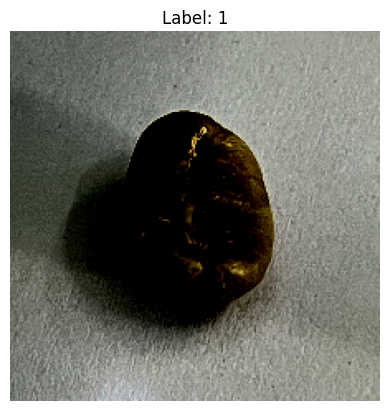

In [70]:
    plt.imshow(image)
    plt.title(f"Label: {label.item()}")  # Используем .item() для получения значения метки
    plt.axis('off')  # Отключаем оси
    plt.show()

In [ ]:
#resnet50(weights=ResNet50_Weights.DEFAULT)

In [72]:
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()

        # подгружаем модель
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        # заменяем слой
        self.model.fc = nn.Linear(2048, 4)
        # замораживаем слои
        for i in self.model.parameters():
            i.requires_grad = False
        # размораживаем только последний, который будем обучать
        self.model.fc.weight.requires_grad = True
        self.model.fc.bias.requires_grad = True

    def forward(self, x):
        return self.model(x)

model = MyResNet()
model.to(DEVICE);

In [73]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = torch.nn.CrossEntropyLoss()

In [74]:
tu.get_model_summary(model, torch.randn(4, 3, 224, 224, device=DEVICE))

Layer                                               Kernel              Output          Params           FLOPs
0_model.Conv2d_conv1                               [3, 64, 7, 7]   [4, 64, 112, 112]       9,408   472,055,808
1_model.BatchNorm2d_bn1                                     [64]   [4, 64, 112, 112]         128    12,845,056
2_model.ReLU_relu                                              -   [4, 64, 112, 112]           0             0
3_model.MaxPool2d_maxpool                                      -     [4, 64, 56, 56]           0             0
4_model.layer1.0.Conv2d_conv1                     [64, 64, 1, 1]     [4, 64, 56, 56]       4,096    51,380,224
5_model.layer1.0.BatchNorm2d_bn1                            [64]     [4, 64, 56, 56]         128     3,211,264
6_model.layer1.0.ReLU_relu                                     -     [4, 64, 56, 56]           0             0
7_model.layer1.0.Conv2d_conv2                     [64, 64, 3, 3]     [4, 64, 56, 56]      36,864   462,422,016
8

In [75]:
train_epoch_acc = []
train_epoch_losses = []
valid_epoch_losses = []
valid_epoch_acc = []

for epoch in range(3):
    model.train()
    loss_batch = []
    acc_batch  = []

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        preds = model(images)  # Убедитесь, что preds имеет размерность [batch_size, num_classes]

        # Вычисление потерь
        loss = criterion(preds, labels.long())  # Убедитесь, что labels имеют правильный тип
        loss_batch.append(loss.item())

        # Вычисление точности
        predicted = torch.argmax(preds, dim=1)  # Получаем индексы классов с максимальной вероятностью
        accuracy = (predicted == labels).cpu().numpy().mean()  # Сравниваем предсказанные классы с метками
        acc_batch.append(accuracy)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_epoch_losses.append(np.mean(loss_batch))
    train_epoch_acc.append(np.mean(acc_batch))

    model.eval()
    loss_batch = []
    acc_batch  = []
    for images, labels in valid_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.no_grad():
            preds = model(images)  # Убедитесь, что preds имеет размерность [batch_size, num_classes]

        loss = criterion(preds, labels.long())  # Убедитесь, что labels имеют правильный тип
        loss_batch.append(loss.item())

        # Вычисление точности
        predicted = torch.argmax(preds, dim=1)  # Получаем индексы классов
        accuracy = (predicted == labels).cpu().numpy().mean()  # Сравниваем предсказанные классы с метками
        acc_batch.append(accuracy)

    valid_epoch_losses.append(np.mean(loss_batch))
    valid_epoch_acc.append(np.mean(acc_batch))

    print(f'Epoch: {epoch}  loss_train: {train_epoch_losses[-1]:.3f}, loss_valid: {valid_epoch_losses[-1]:.3f}')
    print(f'\t  metrics_train: {train_epoch_acc[-1]:.3f}, metrics_valid: {valid_epoch_acc[-1]:.3f}')


Epoch: 0  loss_train: 0.698, loss_valid: 0.371
	  metrics_train: 0.858, metrics_valid: 0.959
Epoch: 1  loss_train: 0.246, loss_valid: 0.157
	  metrics_train: 0.970, metrics_valid: 0.988
Epoch: 2  loss_train: 0.155, loss_valid: 0.115
	  metrics_train: 0.975, metrics_valid: 0.993


In [87]:
model.eval()

MyResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [89]:
test_dataset = torchvision.datasets.ImageFolder(
    '/content/dataset/coffee-beans/test',
    transform=trnsfrms
)

In [90]:
image_path = '/content/drive/MyDrive/Colab Notebooks/img.jpg'
image = Image.open(image_path).convert('RGB')

In [91]:
input_image = trnsfrms(image).unsqueeze(0).to(DEVICE)

In [100]:
start_time = time.time()

In [101]:
with torch.no_grad():
    preds = model(input_image)

In [102]:
probabilities = torch.nn.functional.softmax(preds, dim=1)

In [103]:
top4_prob, top4_catid = torch.topk(probabilities, 4)

In [104]:
top_probs = top4_prob.squeeze().cpu().numpy()
top_classes = top4_catid.squeeze().cpu().numpy()

In [105]:
end_time = time.time()
execution_time = end_time - start_time

In [108]:
print("Предсказанные классы и вероятности:")
for i in range(4):
    print(f"Класс: {top_classes[i]}, Вероятность: {top_probs[i]:.3f}")

print(f"Время выполнения: {execution_time:.3f} секунд")

Предсказанные классы и вероятности:
Класс: 3, Вероятность: 0.945
Класс: 2, Вероятность: 0.055
Класс: 1, Вероятность: 0.001
Класс: 0, Вероятность: 0.000
Время выполнения: 6.705 секунд


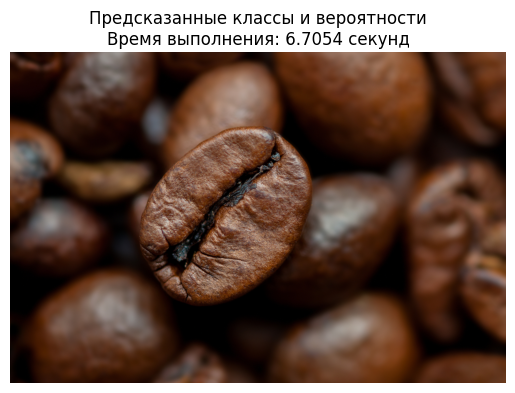

In [124]:
pred_class = probabilities.argmax(dim=1).item()


plt.imshow(image)
plt.axis('off')
plt.title(f'Предсказанные классы и вероятности\nВремя выполнения: {execution_time:.4f} секунд')
plt.show()

In [125]:
def plot_learning_curves(train_epoch_losses, valid_epoch_losses, train_epoch_acc, valid_epoch_acc):
    epochs = range(1, len(train_epoch_losses) + 1)

    # График потерь
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_epoch_losses, label='Train Loss', color='blue')
    plt.plot(epochs, valid_epoch_losses, label='Valid Loss', color='orange')
    plt.title('Loss functions')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_epoch_acc, label='Train Accuracy', color='blue')
    plt.plot(epochs, valid_epoch_acc, label='Valid Accuracy', color='orange')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/learning_curves.png')
    plt.show()

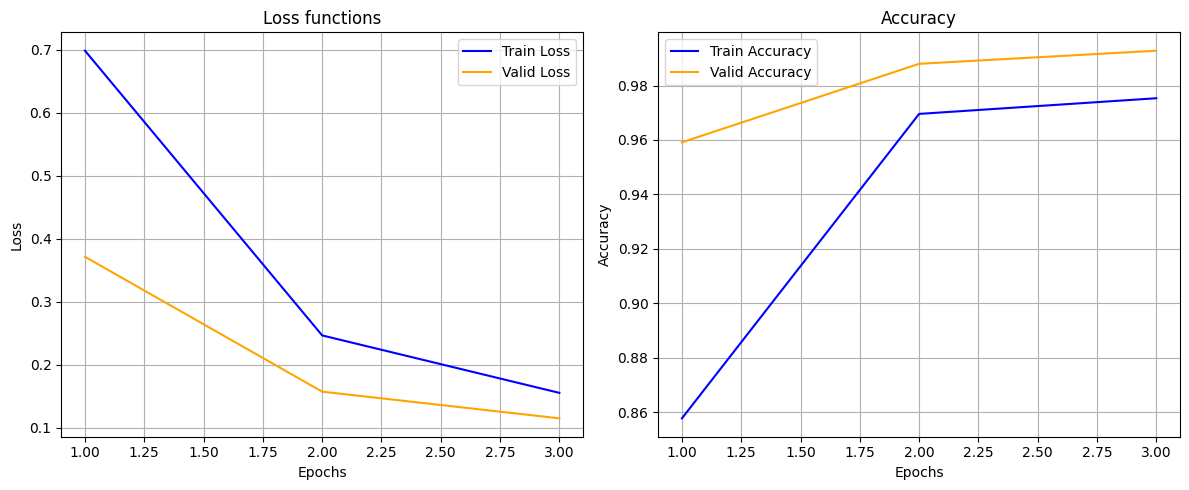

In [126]:
plot_learning_curves(train_epoch_losses, valid_epoch_losses, train_epoch_acc, valid_epoch_acc)

состояние модели и оптимизатора в файл

In [85]:
torch.save(model.state_dict(),'/content/drive/MyDrive/Colab Notebooks/model_resnet.pth')

In [127]:
true_labels = []
predicted_labels = []

In [133]:
with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f'F1 Score: {f1:.3f}')

F1 Score: 0.992


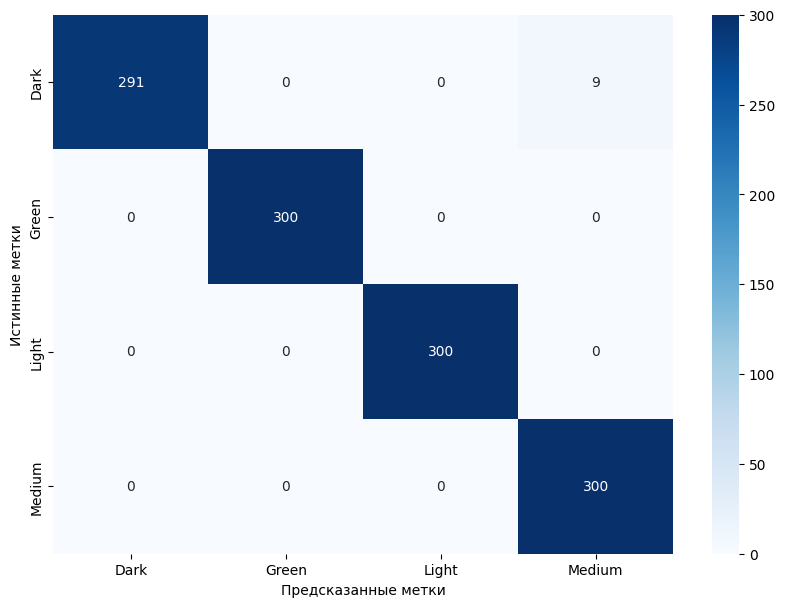

In [139]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/heatmap.png')